In [ ]:
pip install pyorbital

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.3/75.3 kB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyorbital: filename=pyorbital-1.7.3-py2.py3-none-any.whl size=62444 sha256=940780c1f3052578f0a789e3a109acdf373434256ca43e920608cbf91689fe8b
  Stored in directory: /root/.cache/pip/wheels/76/01/59/ceaeb748bcd6594db154f4ffa6fa56b02466a8e1a051a95d51
Successfully built pyorbital


In [ ]:
!pip install ipython-autotime
%load_ext autotime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 31.5 MB/s eta 0:00:00
time: 367 µs (started: 2023-06-22 01:03:57 +00:00)


In [ ]:
import jax.numpy as jnp
import jax
from pyorbital.orbital import Orbital
from datetime import datetime,timedelta
import numpy as np

time: 3.69 s (started: 2023-06-22 01:03:57 +00:00)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
time: 21.1 s (started: 2023-06-15 01:12:33 +00:00)


In [ ]:
#/content/drive/MyDrive/Jupyter/starlink/starlink_short.txt

NameError: ignored

time: 171 ms (started: 2023-05-26 20:55:48 +00:00)


In [ ]:
@jax.jit
def convert_ecf(lat, lon, alt):
    alt = alt * 1000
    lat = lat * (np.pi / 180)
    lon = lon * (np.pi / 180)
    e = 0.003353
    R = 6378100 / jnp.sqrt(1 - (e**2) * (jnp.sin(lat))**2)
    x = (R + alt) * jnp.cos(lat) * jnp.cos(lon)
    y = (R + alt) * jnp.cos(lat) * jnp.sin(lon)
    z = ((1 - e**2) * R + alt) * jnp.sin(lat)
    return x, y, z

time: 1.24 ms (started: 2023-06-15 01:12:54 +00:00)


In [ ]:
@jax.jit
def true_fn(x):
    return x


@jax.jit
def false_fn(x):
    return 0.0
@jax.jit
def distance(obs, tar):
    obs_x, obs_y, obs_z = obs[0], obs[1], obs[2]
    tar_x, tar_y, tar_z = tar[0], tar[1], tar[2]
    zero = 0
    length = jnp.sqrt((obs_x - tar_x)**2 + (obs_y - tar_y)**2 +
                      (obs_z - tar_z)**2) / 1000
    # if length < 5016:
    #   return length
    # else:
    #   return zero
    return jax.lax.cond(length < 606, true_fn, false_fn, length)
    #return jnp.sqrt((obs_x-tar_x)**2+(obs_y-tar_y)**2+(obs_z-tar_z)**2)/1000

time: 5.49 ms (started: 2023-06-15 01:12:54 +00:00)


In [ ]:
name_list = []
connection_conunt = {}
line_count = 0
count = 0
with open('/content/drive/MyDrive/Jupyter/starlink/starlink.txt') as file:
    for line in file:
        striped_line = line.rstrip()
        if line_count == 0:
            name = striped_line
            if name[:8] == "STARLINK":
                name_list.append(name)
                connection_conunt[name] = 0
                count += 1
        line_count += 1
        if line_count == 3:
            line_count = 0
pos_list = []
pos_list_plus_t = []
time_now = datetime.utcnow()
time_plus_x = time_now + timedelta(minutes=2)
length = len(name_list)
for i in range(length):
    sat = Orbital(
        name_list[i],
        tle_file='/content/drive/MyDrive/Jupyter/starlink/starlink.txt')
    #print(name_list[i])
    sat_lon, sat_lat, sat_alt = sat.get_lonlatalt(time_now)
    pos_list.append(convert_ecf(sat_lat, sat_lon, sat_alt))
    sat_lon, sat_lat, sat_alt = sat.get_lonlatalt(time_plus_x)
    pos_list_plus_t.append(convert_ecf(sat_lat, sat_lon, sat_alt))
satellite_matrix = jnp.zeros((length, length))
pos_list = jnp.asarray(pos_list)

time: 53.9 s (started: 2023-06-15 01:13:00 +00:00)


In [ ]:
from jax import vmap
import jax.numpy as jnp
from functools import partial


def f1(x, y):
    assert x[0].ndim == y[0].ndim == 0
    assert x[1].ndim == y[1].ndim == 0
    assert x[2].ndim == y[2].ndim == 0
    return 0


def f2(x, y):
    assert x[0].ndim == y[0].ndim == 0
    assert x[1].ndim == y[1].ndim == 0
    assert x[2].ndim == y[2].ndim == 0
    return distance(x, y)


@partial(vmap, in_axes=(0, None))
@partial(vmap, in_axes=(None, 0))
def g(i, j):
    return jnp.where(i == j, f1(pos_list[i], pos_list[j]),
                     f2(pos_list[i], pos_list[j]))


pos_matrix = g(jnp.arange(len(pos_list)), jnp.arange(len(pos_list)))

time: 2.84 s (started: 2023-06-15 01:13:55 +00:00)


In [ ]:
def scan_fun(count, row):
    row = jnp.where(count >= 4, 0, row)
    _, indices = jax.lax.top_k(row, 4)
    c_row = jnp.zeros_like(row).at[indices].set(1)
    c_row = jnp.where(row == 0, 0, c_row)
    count += (c_row > 0)
    return count, c_row


_, c_matrix = jax.lax.scan(scan_fun, jnp.zeros_like(pos_matrix[0]), pos_matrix)

time: 2.58 s (started: 2023-06-15 01:13:58 +00:00)


In [ ]:
def get_datarate(distance):
  d = distance*1000 #distance between two satellite in meter
  k = 1.38e-23 #boltzman constant
  t = 250 # temperture in k
  n0 = k*t
  dia = 0.25 # diameter for antenna in meter
  wl = 1550e-9 # Wavelength in meter
  pt = -10 #dbw
  eff_fact = 0.65 # efficiency factor of  antenna
  gi = 10*jnp.log10(eff_fact*((jnp.pi*dia)/wl)**2) # Gain for receive and transimit
  fspl = 20*jnp.log10((4*jnp.pi*d)/wl) + 50
  pr = pt + gi+gi - fspl
  pr_dbwatt = 10**(pr/10) #pr dbw to watt
  Rb = ((pr_dbwatt)/(n0))/(10**(12/10))#data rate in bps
  return int(Rb)

time: 938 µs (started: 2023-06-22 01:05:05 +00:00)


In [ ]:
4*jnp.pi*d)/wl

In [ ]:
get_datarate(606)*1e-9

21.102725120000002

time: 6.35 ms (started: 2023-06-22 01:12:41 +00:00)


In [ ]:
import networkx as nx
G = nx.DiGraph()
for i in range(length):
  indices = jnp.flatnonzero(c_matrix[i])
  if jnp.size(indices) !=0:
    for j in indices:
      distance = int(pos_matrix[i,j])
      G.add_edge(i, int(j),weight= round(pos_matrix[i,int(j)]/3e5*1000,2)
      ,capacity=get_datarate(distance))

time: 3min 5s (started: 2023-06-15 01:14:00 +00:00)


In [ ]:
nx.algebraic_connectivity(G)

NetworkXNotImplemented: ignored

time: 21.5 ms (started: 2023-05-26 23:58:23 +00:00)


In [ ]:
#NY to Syn
source = name_list.index("STARLINK-1688")
sink = name_list.index("STARLINK-3389")

time: 664 µs (started: 2023-06-15 01:17:06 +00:00)


In [ ]:
#NY to Lon
source = name_list.index("STARLINK-2286")
sink = name_list.index("STARLINK-5155")

time: 791 µs (started: 2023-06-14 23:36:55 +00:00)


In [ ]:
nx.has_path(G,source,sink)

True

time: 7.92 ms (started: 2023-06-15 01:17:06 +00:00)


In [ ]:
short_path = nx.shortest_path(G,source,sink,weight = 'weight',method='dijkstra')
len(short_path)

49

time: 14.6 s (started: 2023-06-15 01:17:07 +00:00)


In [ ]:
nx.path_weight(G,short_path,weight = 'weight')

Array(81.14999, dtype=float32)

time: 10.3 ms (started: 2023-06-15 01:17:21 +00:00)


In [ ]:
if nx.has_path(G,source,sink):
  G.add_node(source, demand=-100)
  G.add_node(sink, demand= 100)
  flowCost, flowDict = nx.capacity_scaling(G)


KeyboardInterrupt: ignored

time: 8min 42s (started: 2023-06-15 01:17:26 +00:00)


In [ ]:
print(nx.maximum_flow(G,source,sink))
path = ([ (u,v) for u in flowDict for v in flowDict[u] if flowDict[u][v]>0])
F = nx.DiGraph(path)
nx.has_path(F,source,sink)
path_dict = {}
for path in list(nx.all_shortest_paths(F, source, sink)):
    weight = nx.path_weight(G,path,weight="weight")
    path_dict[len(path)] = weight

In [ ]:
path_dict

In [ ]:
G = nx.DiGraph()
G.add_node("a", demand=-5)
G.add_node("d", demand=5)
G.add_edge("a", "b", weight=3, capacity=4)
G.add_edge("a", "c", weight=6, capacity=10)

time: 729 µs (started: 2023-06-15 01:26:36 +00:00)


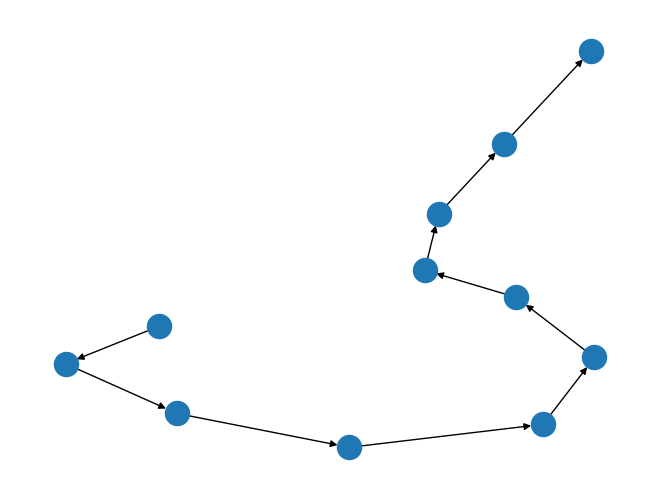

time: 349 ms (started: 2023-05-26 22:53:30 +00:00)


In [ ]:
nx.draw(F)

In [ ]:
import networkx as nx
Z = nx.DiGraph()
Z.add_edge("a", "b", weight=3, capacity=4)
Z.add_edge("a", "c", weight=6, capacity=10)
Z.add_edge("b", "d", weight=1, capacity=9)
Z.add_edge("c", "d", weight=2, capacity=5)
Z.add_edge("s", "a", weight=0, capacity=100000)
flowCost, flowDict = nx.capacity_scaling(Z)
flowDict

{'a': {'b': 0, 'c': 0}, 'b': {'d': 0}, 'c': {'d': 0}, 'd': {}, 's': {'a': 0}}

time: 8.83 ms (started: 2023-05-26 22:45:59 +00:00)


In [ ]:
nx.node_connectivity(G)


0

time: 3.61 ms (started: 2023-05-26 21:14:30 +00:00)


In [ ]:
np.savetxt("/content/drive/MyDrive/Jupyter/starlink/colabfoocmatrix.csv", c_matrix, delimiter=",")

time: 14.1 s (started: 2023-05-25 17:41:06 +00:00)


In [ ]:
import networkx as nx
G = nx.DiGraph()
G.add_edges_from(
    [
        (1, 2, {"capacity": 12, "weight": 4}),
        (1, 3, {"capacity": 20, "weight": 6}),
        (2, 3, {"capacity": 6, "weight": -3}),
        (2, 6, {"capacity": 14, "weight": 1}),
        (3, 4, {"weight": 9}),
        (3, 5, {"capacity": 10, "weight": 5}),
        (4, 2, {"capacity": 19, "weight": 13}),
        (4, 5, {"capacity": 4, "weight": 0}),
        (5, 7, {"capacity": 28, "weight": 2}),
        (6, 5, {"capacity": 11, "weight": 1}),
        (6, 7, {"weight": 8}),
        (7, 4, {"capacity": 6, "weight": 6}),
    ]
)
mincostFlow = nx.node_connectivity(G)
mincostFlow

1

In [ ]:
print(nx.maximum_flow(G,1,4))

(32, {1: {2: 12, 3: 20}, 2: {3: 6, 6: 6}, 3: {4: 26, 5: 0}, 6: {5: 0, 7: 6}, 4: {2: 0, 5: 0}, 5: {7: 0}, 7: {4: 6}})


In [ ]:
mincost = nx.cost_of_flow(G, mincostFlow)
mincost

373

In [ ]:
G = nx.DiGraph()
G.add_node("a", demand=-5)
G.add_node("f", demand=5)
G.add_edge("a", "b", weight=3, capacity=4)
G.add_edge("a", "c", weight=6, capacity=10)
G.add_edge("b", "d", weight=1, capacity=9)
G.add_edge("c", "d", weight=2, capacity=5)
G.add_edge("b", "e", weight=3, capacity=4)
G.add_edge("e", "c", weight=1, capacity=13)
G.add_edge("e", "f", weight=3, capacity=2)
G.add_edge("d", "f", weight=1, capacity=12)

flowDict = nx.min_cost_flow(G)

In [ ]:
#heaviest_path

['a', 'c', 'd']

In [ ]:
# heaviest_path = max((path for path in nx.all_simple_paths(G, "a", "f")),
#                     key=lambda path: nx.path_weight(G,path,weight="weight"))
# heaviest_path

['a', 'b', 'e', 'c', 'd', 'f']

In [ ]:
# sum = 0
# G = nx.DiGraph()
# G.add_node("a", demand=-5)
# G.add_node("f", demand=5)
# G.add_edge("a", "b", weight=3, capacity=4)
# G.add_edge("a", "c", weight=6, capacity=10)
# G.add_edge("b", "d", weight=1, capacity=9)
# G.add_edge("c", "d", weight=2, capacity=5)
# G.add_edge("b", "e", weight=3, capacity=4)
# G.add_edge("e", "c", weight=1, capacity=13)
# G.add_edge("e", "f", weight=3, capacity=2)
# G.add_edge("d", "f", weight=1, capacity=12)
# flowCost, flowDict = nx.capacity_scaling(G)
# path = ([ (u,v) for u in flowDict for v in flowDict[u] if flowDict[u][v]>0])
# F = nx.DiGraph(path)
# for path in list(nx.all_shortest_paths(F, "a", "f")):
#     weight = nx.path_weight(G,path,weight="weight")
#     print(path)
#     if weight >= sum:
#         sum = weight
# print(sum)

['a', 'b', 'd', 'f']
['a', 'c', 'd', 'f']
9


In [ ]:
# G = nx.DiGraph()
# G.add_node("a", demand=-5)
# G.add_node("f", demand=5)
# G.add_edge("a", "b", weight=3, capacity=4)
# G.add_edge("a", "c", weight=6, capacity=10)
# G.add_edge("b", "d", weight=1, capacity=9)
# G.add_edge("c", "d", weight=2, capacity=6)
# G.add_edge("b", "e", weight=3, capacity=4)
# G.add_edge("e", "c", weight=1, capacity=13)
# G.add_edge("e", "f", weight=3, capacity=2)
# G.add_edge("d", "f", weight=1, capacity=12)
# print(nx.maximum_flow(G,"a","f"))

# flowCost, flowDict = nx.capacity_scaling(G)
# path = ([ (u,v) for u in flowDict for v in flowDict[u] if flowDict[u][v]>0])
# F = nx.DiGraph(path)
# for path in list(nx.all_shortest_paths(F, "a", "f")):
#     weight = nx.path_weight(G,path,weight="weight")
#     print(path)
#     if weight >= sum:
#         sum = weight
# print(sum)

(10, {'a': {'b': 4, 'c': 6}, 'f': {}, 'b': {'d': 4, 'e': 0}, 'c': {'d': 6}, 'd': {'f': 10}, 'e': {'c': 0, 'f': 0}})
['a', 'b', 'd', 'f']
['a', 'c', 'd', 'f']
9


In [ ]:
#flowDict

{'a': {'b': 4, 'c': 1},
 'f': {},
 'b': {'d': 4, 'e': 0},
 'c': {'d': 1},
 'd': {'f': 5},
 'e': {'c': 0, 'f': 0}}